<br></br>
# **나이브베이즈 한글 적용**
nltk를 활용한 네이버 영화리뷰 평가모델 [nltk book](https://www.nltk.org/book/ch06.html) | [nltk How to](http://www.nltk.org/howto/classify.html)
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [1]:
! cat ./data/ratings_test.txt | head -n 10

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0
cat: 쓰기 오류: 파이프가 깨어짐


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/50)) ]
    return random_data

train_data = read_data('./data/ratings_train.txt')
test_data  = read_data('./data/ratings_test.txt')
print('Train_data ({})\nsample : {}\nTest_data  ({})\nsample : {}'.format(
    len(train_data), train_data[:3],
    len(test_data),  test_data[:3]))

Train_data (3000)
sample : [['10125128', '초반부는 그럴듯한데, 끝까지 보면 시간 아까울 거야', '0'], ['6663312', '당신이 영화감독이라고 치고 자신의 의식과 무의식간(꿈)의 관계의 대립과 갈등, 화해 등의 과정을 영화속에 담아봐. 그 영화는 어때? 김기덕의 경우는 해피엔딩인듯', '1'], ['4776867', '여성의 심리까지 통달한 프로이드가 울고갈 심리의 신!', '1']]
Test_data  (1000)
sample : [['3491296', '엘렌페이지 땜 봤는데 재밌었어요, 대사도 유쾌하고 아 미사랑은 상관없답니다 ㅋㅋ', '1'], ['9683776', '허달프, 보드라미 쭈누님, 쿡테러리스트 김풍,우완전 재밌다는 삼국지도 아니고 ㅋ 자취요리 춘추전국시대', '1'], ['3088613', '요즘 시대에 이런 영화가 그립다', '1']]


In [3]:
%%time
from konlpy.tag import Twitter
twitter = Twitter()

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['초반/Noun',
   '불다/Verb',
   '그럴듯하다/Adjective',
   ',/Punctuation',
   '끝/Noun',
   '까지/Josa',
   '보다/Verb',
   '시간/Noun',
   '아깝다/Adjective'],
  '0'),
 (['당신/Noun',
   '이/Josa',
   '영화감독/Noun',
   '이라고/Josa',
   '치고/Josa',
   '자신/Noun',
   '의/Josa',
   '의식/Noun',
   '과/Josa',
   '무의식/Noun',
   '간/Suffix',
   '(/Punctuation',
   '꿈/Noun',
   ')/Punctuation',
   '의/Noun',
   '관계/Noun',
   '의/Josa',
   '대립/Noun',
   '과/Josa',
   '갈등/Noun',
   ',/Punctuation',
   '화해/Noun',
   '등/Noun',
   '의/Josa',
   '과정/Noun',
   '을/Josa',
   '영화/Noun',
   '속/Noun',
   '에/Josa',
   '담다/Verb',
   '봐/Noun',
   './Punctuation',
   '그/Noun',
   '영화/Noun',
   '는/Josa',
   '어떻다/Adjective',
   '?/Punctuation',
   '김기덕/Noun',
   '의/Josa',
   '경우/Noun',
   '는/Josa',
   '해피엔딩/Noun',
   '인/Josa',
   '듯/Noun'],
  '1')]
CPU times: user 14.7 s, sys: 208 ms, total: 14.9 s
Wall time: 6.93 s


In [4]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:5]))

Token Total :44777
Sample : ['초반/Noun', '불다/Verb', '그럴듯하다/Adjective', ',/Punctuation', '끝/Noun']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [5]:
import nltk
text = nltk.Text(tokens, name='NMSC')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common(5))    

number of Token : 44777 
unique Token    : 6664

[('./Punctuation', 1491),
 ('영화/Noun', 1084),
 ('하다/Verb', 1045),
 ('이/Josa', 785),
 ('보다/Verb', 692)]


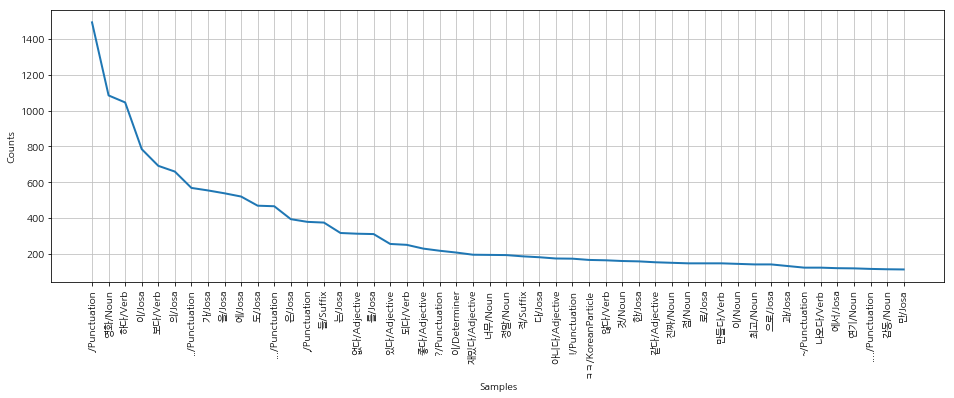

In [6]:
%matplotlib inline
from matplotlib import rc
rc('font', family=['NanumGothic','Malgun Gothic'])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot(50) 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [7]:
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '이/Josa', '보다/Verb']

In [8]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_docs = train_docs[:10000]
train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 16.1 s, sys: 660 ms, total: 16.8 s
Wall time: 16.8 s


In [9]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 15.8 s, sys: 97 µs, total: 15.8 s
Wall time: 15.8 s


<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [10]:
classifiers.labels()

['0', '1']

In [11]:
classifiers.show_most_informative_features(20)

Most Informative Features
         exists(최악/Noun) = True                0 : 1      =     22.8 : 1.0
         exists(명작/Noun) = True                1 : 0      =     19.8 : 1.0
   exists(슬프다/Adjective) = True                1 : 0      =     18.5 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     17.7 : 1.0
         exists(짜증/Noun) = True                0 : 1      =     16.2 : 1.0
         exists(별로/Noun) = True                0 : 1      =     13.3 : 1.0
         exists(최고/Noun) = True                1 : 0      =     12.1 : 1.0
    exists(깊다/Adjective) = True                1 : 0      =     11.1 : 1.0
    exists(뭔/NounPrefix) = True                0 : 1      =     10.9 : 1.0
   exists(아깝다/Adjective) = True                0 : 1      =     10.9 : 1.0
          exists(접/Noun) = True                0 : 1      =     10.3 : 1.0
         exists(문제/Noun) = True                0 : 1      =     10.3 : 1.0
       exists(떨어지다/Verb) = True                0 : 1      =     10.3 : 1.0

In [12]:
%%time
'네이버 긍부정 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 11.6 s, sys: 8.21 ms, total: 11.6 s
Wall time: 11.6 s


'네이버 긍부정 모델의 Accuracy : 0.754'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [13]:
review = """약간지루합니다. 
스토리도 작의적인부분이 있고.. 스케일이 크지도않네요. 
역사고발이라는측면에서는 의의가 있다고봅니다"""

In [14]:
review = tokenize(review)    # 문법 Tag 추가한 객체로 변환
review

['약간/Noun',
 '지루하다/Adjective',
 './Punctuation',
 '스토리/Noun',
 '도/Josa',
 '작/Noun',
 '의적/Noun',
 '인/Josa',
 '부분/Noun',
 '이/Josa',
 '있다/Adjective',
 '../Punctuation',
 '스케일/Noun',
 '이/Josa',
 '크다/Verb',
 '않다/Verb',
 './Punctuation',
 '역사/Noun',
 '고발/Noun',
 '이라는/Josa',
 '측면/Noun',
 '에서는/Josa',
 '의의/Noun',
 '가/Josa',
 '있다/Adjective',
 '보다/Verb']

In [15]:
review = term_exists(review) # 기준 용어들이 포함여부 판단
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(./Punctuation) = True
exists(이/Josa) = True
exists(보다/Verb) = True
exists(../Punctuation) = True
exists(가/Josa) = True
exists(도/Josa) = True
exists(있다/Adjective) = True
exists(않다/Verb) = True
exists(스토리/Noun) = True
exists(인/Josa) = True
exists(지루하다/Adjective) = True
exists(크다/Verb) = True
exists(부분/Noun) = True
exists(이라는/Josa) = True
exists(역사/Noun) = True
exists(약간/Noun) = True
exists(스케일/Noun) = True
exists(에서는/Josa) = True
exists(고발/Noun) = True
exists(작/Noun) = True


In [16]:
classifiers.classify(review)  # 분류모델 평가

'1'